## Import Dependencies

In [1]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from IPython.display import display
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch, DataLoader
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImage,
    SaveImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    Activations,
    AddChannel,
    RandRotate,
    AsChannelFirst,
    AsChannelLast, 
    RandFlip,
    ToTensor,
    Resize,
)
from monai.visualize import plot_2d_or_3d_image


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision.transforms import Lambda
from monai.utils.misc import first
from monai.utils import set_determinism
import random


In [3]:
def seed_everything(seed=1234):
    # source: https://github.com/pytorch/pytorch/issues/11278
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 2.0.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: C:\Users\anami\.conda\envs\ml\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.10.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.0
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.24.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-re

In [5]:
torch.cuda.empty_cache()

## Import Files

In [6]:
# define all parameters:
nr_train_samples = 40
nr_val_samples = 40

In [7]:
# import training images 

ng_image_dir = "./data/Training400/Non-Glaucoma"
ng_images = [os.path.join(ng_image_dir, i) for i in os.listdir(ng_image_dir)]

g_image_dir = "./data/Training400/Glaucoma"
g_images = [os.path.join(g_image_dir, i) for i in os.listdir(g_image_dir)]

train_images = g_images + ng_images
train_images

['C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training400\\Glaucoma\\g0001.jpg',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training400\\Glaucoma\\g0002.jpg',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training400\\Glaucoma\\g0003.jpg',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training400\\Glaucoma\\g0004.jpg',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training400\\Glaucoma\\g0005.jpg',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training400\\Glaucoma\\g0006.jpg',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detectio

In [8]:
# import training segmentation masks 

ng_gt_dir = "C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training400-GT\\Disc_Cup_Masks\\Non-Glaucoma"
ng_gt = [os.path.join(ng_gt_dir, i) for i in os.listdir(ng_gt_dir)]

g_gt_dir = "C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training400-GT\\Disc_Cup_Masks\\Glaucoma"
g_gt = [os.path.join(g_gt_dir, i) for i in os.listdir(g_gt_dir)]

train_masks = g_gt + ng_gt
train_masks

['C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training400-GT\\Disc_Cup_Masks\\Glaucoma\\g0001.bmp',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training400-GT\\Disc_Cup_Masks\\Glaucoma\\g0002.bmp',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training400-GT\\Disc_Cup_Masks\\Glaucoma\\g0003.bmp',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training400-GT\\Disc_Cup_Masks\\Glaucoma\\g0004.bmp',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training400-GT\\Disc_Cup_Masks\\Glaucoma\\g0005.bmp',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\Training40

In [9]:
# import validation images 

val_image_dir = "C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validation400"
val_images = [os.path.join(val_image_dir, i) for i in os.listdir(val_image_dir)]

val_images

['C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validation400\\V0001.jpg',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validation400\\V0002.jpg',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validation400\\V0003.jpg',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validation400\\V0004.jpg',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validation400\\V0005.jpg',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validation400\\V0006.jpg',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6

In [10]:
# import validation segmentation masks

val_gt_dir = "C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validation400-GT\\Disc_Cup_Masks"
val_masks = [os.path.join(val_gt_dir, i) for i in os.listdir(val_gt_dir)]

val_masks

['C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validation400-GT\\Disc_Cup_Masks\\V0001.bmp',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validation400-GT\\Disc_Cup_Masks\\V0002.bmp',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validation400-GT\\Disc_Cup_Masks\\V0003.bmp',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validation400-GT\\Disc_Cup_Masks\\V0004.bmp',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validation400-GT\\Disc_Cup_Masks\\V0005.bmp',
 'C:\\Users\\anami\\OneDrive\\Desktop\\MDM\\project\\glaucoma-detection-bme6938\\src\\notebooks\\anamitra\\u-net\\data\\REFUGE-Validati

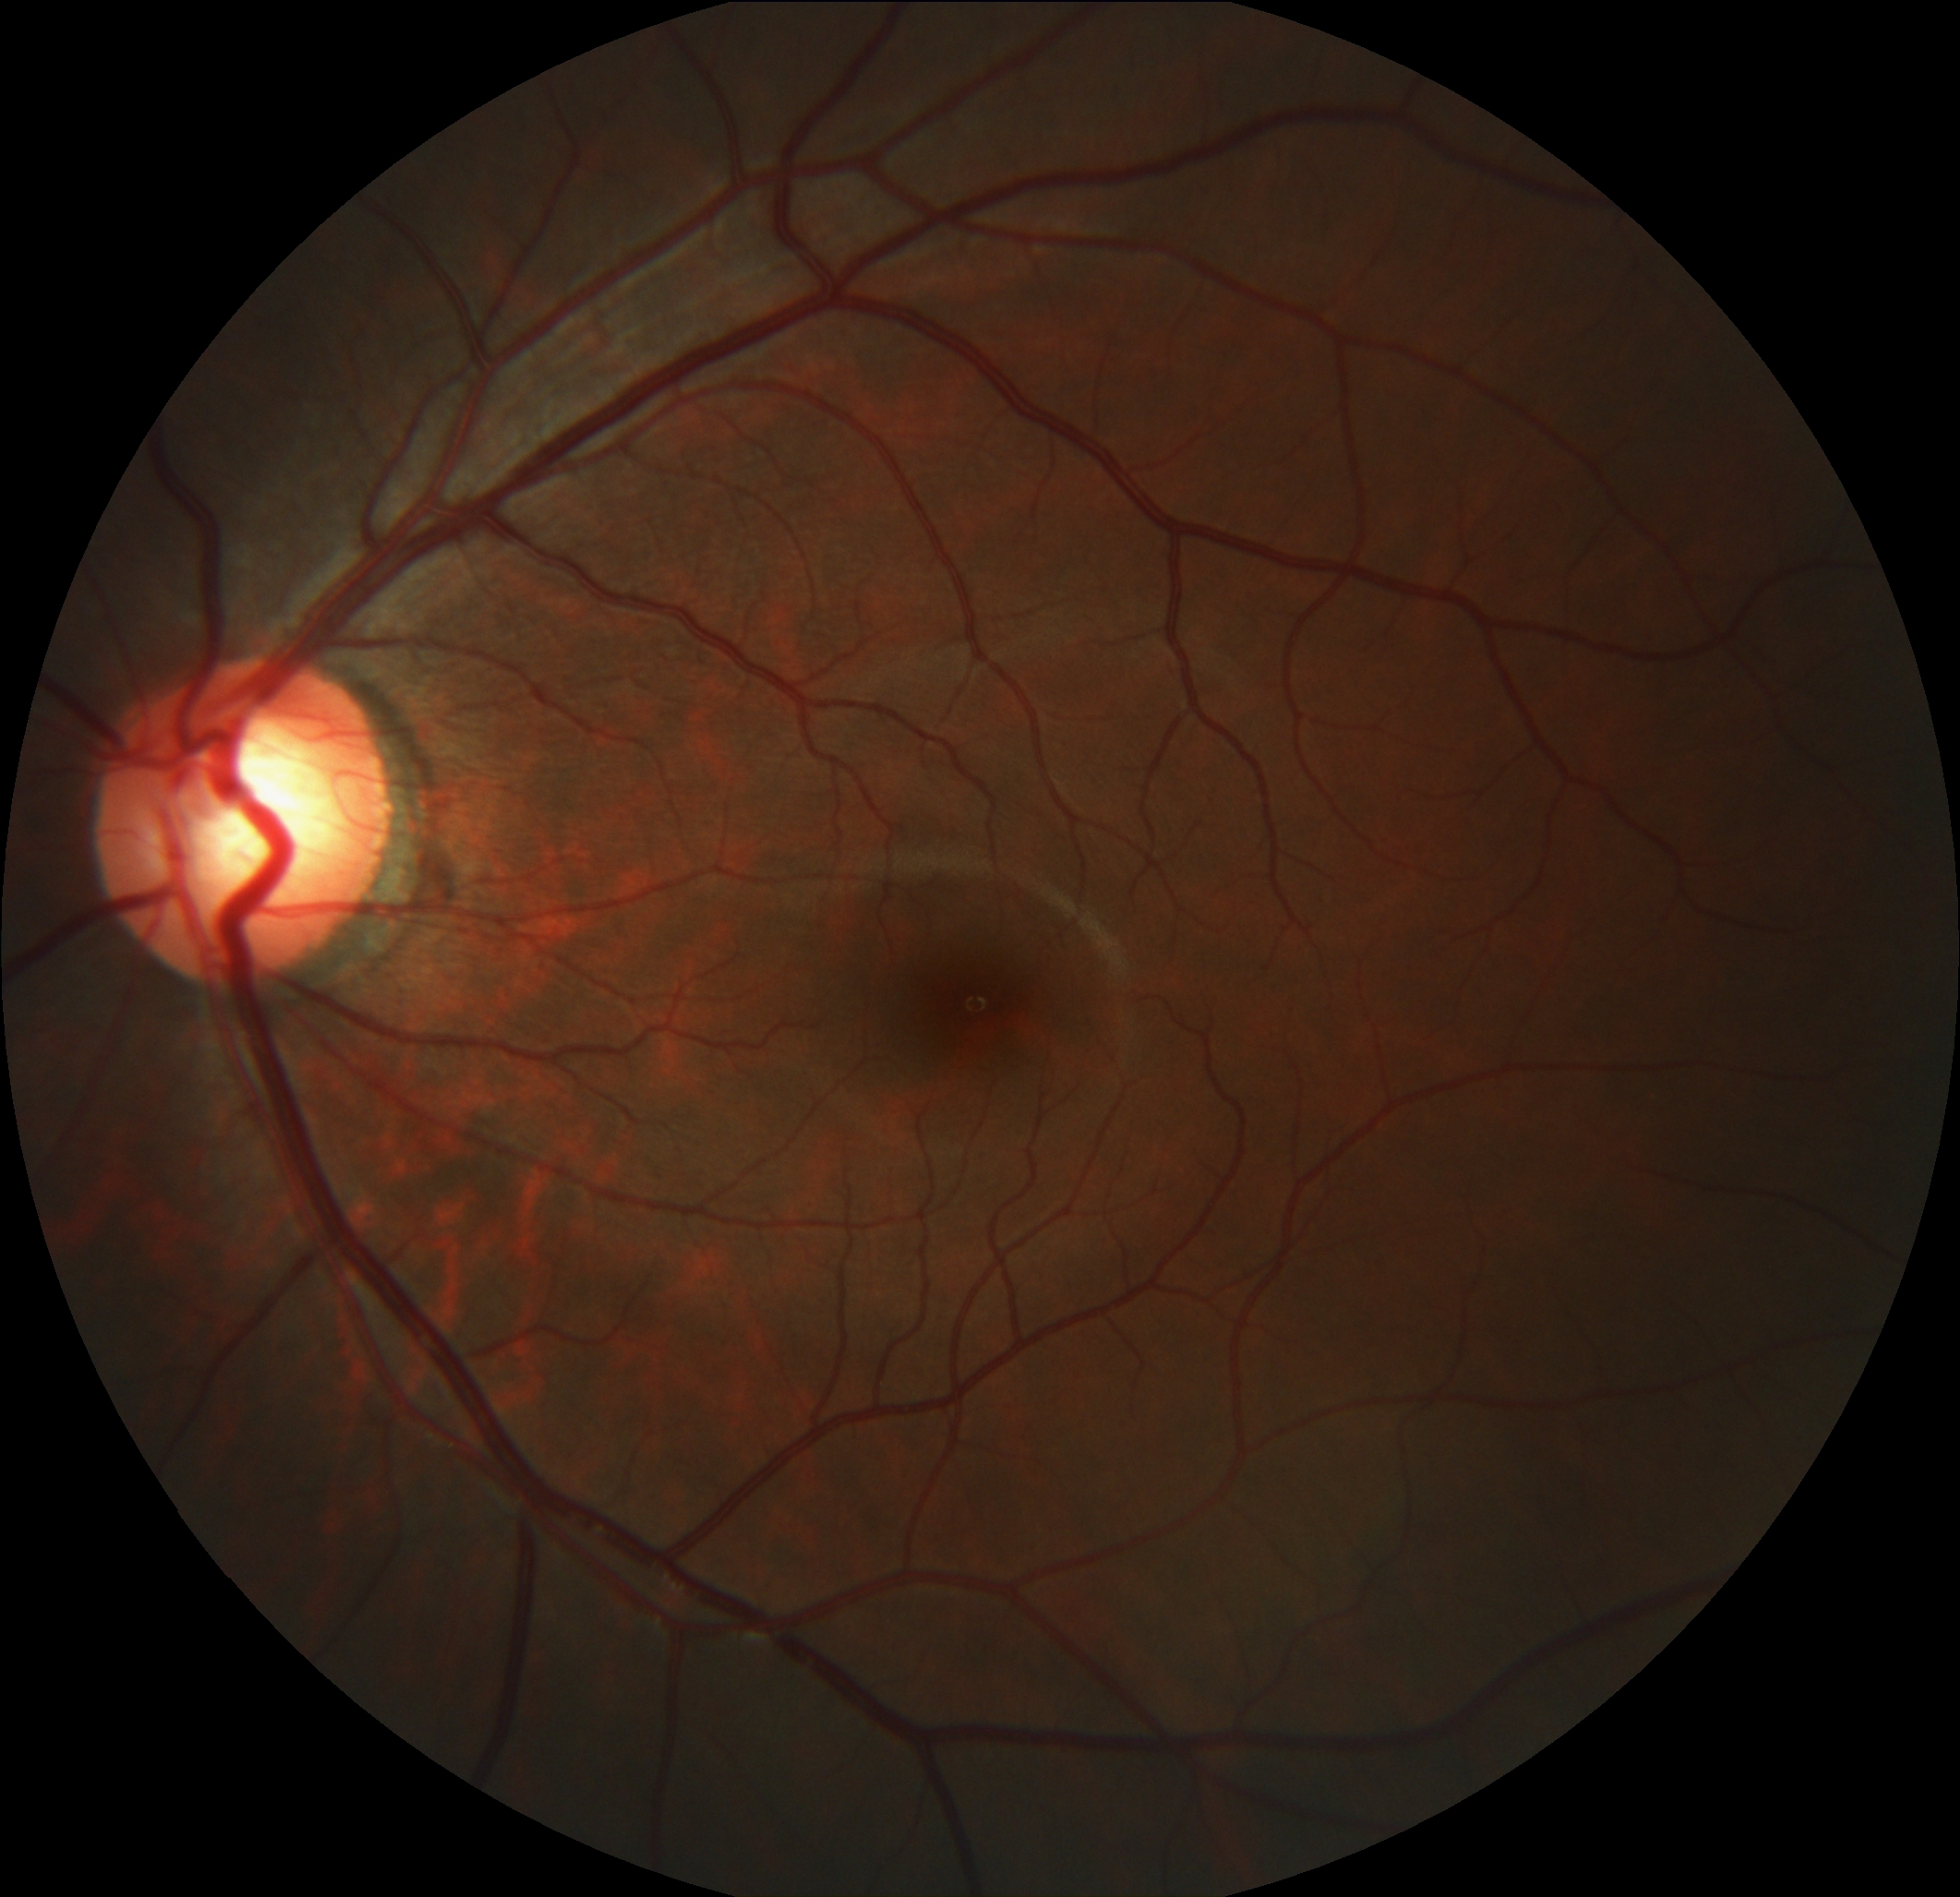

Image format: JPEG
Image size: (2124, 2056)
Image mode: RGB


In [11]:
# open the image file using PIL
image = Image.open(train_images[0])

# display the image
display(image)

# print the image details
print("Image format:", image.format)
print("Image size:", image.size)
print("Image mode:", image.mode)

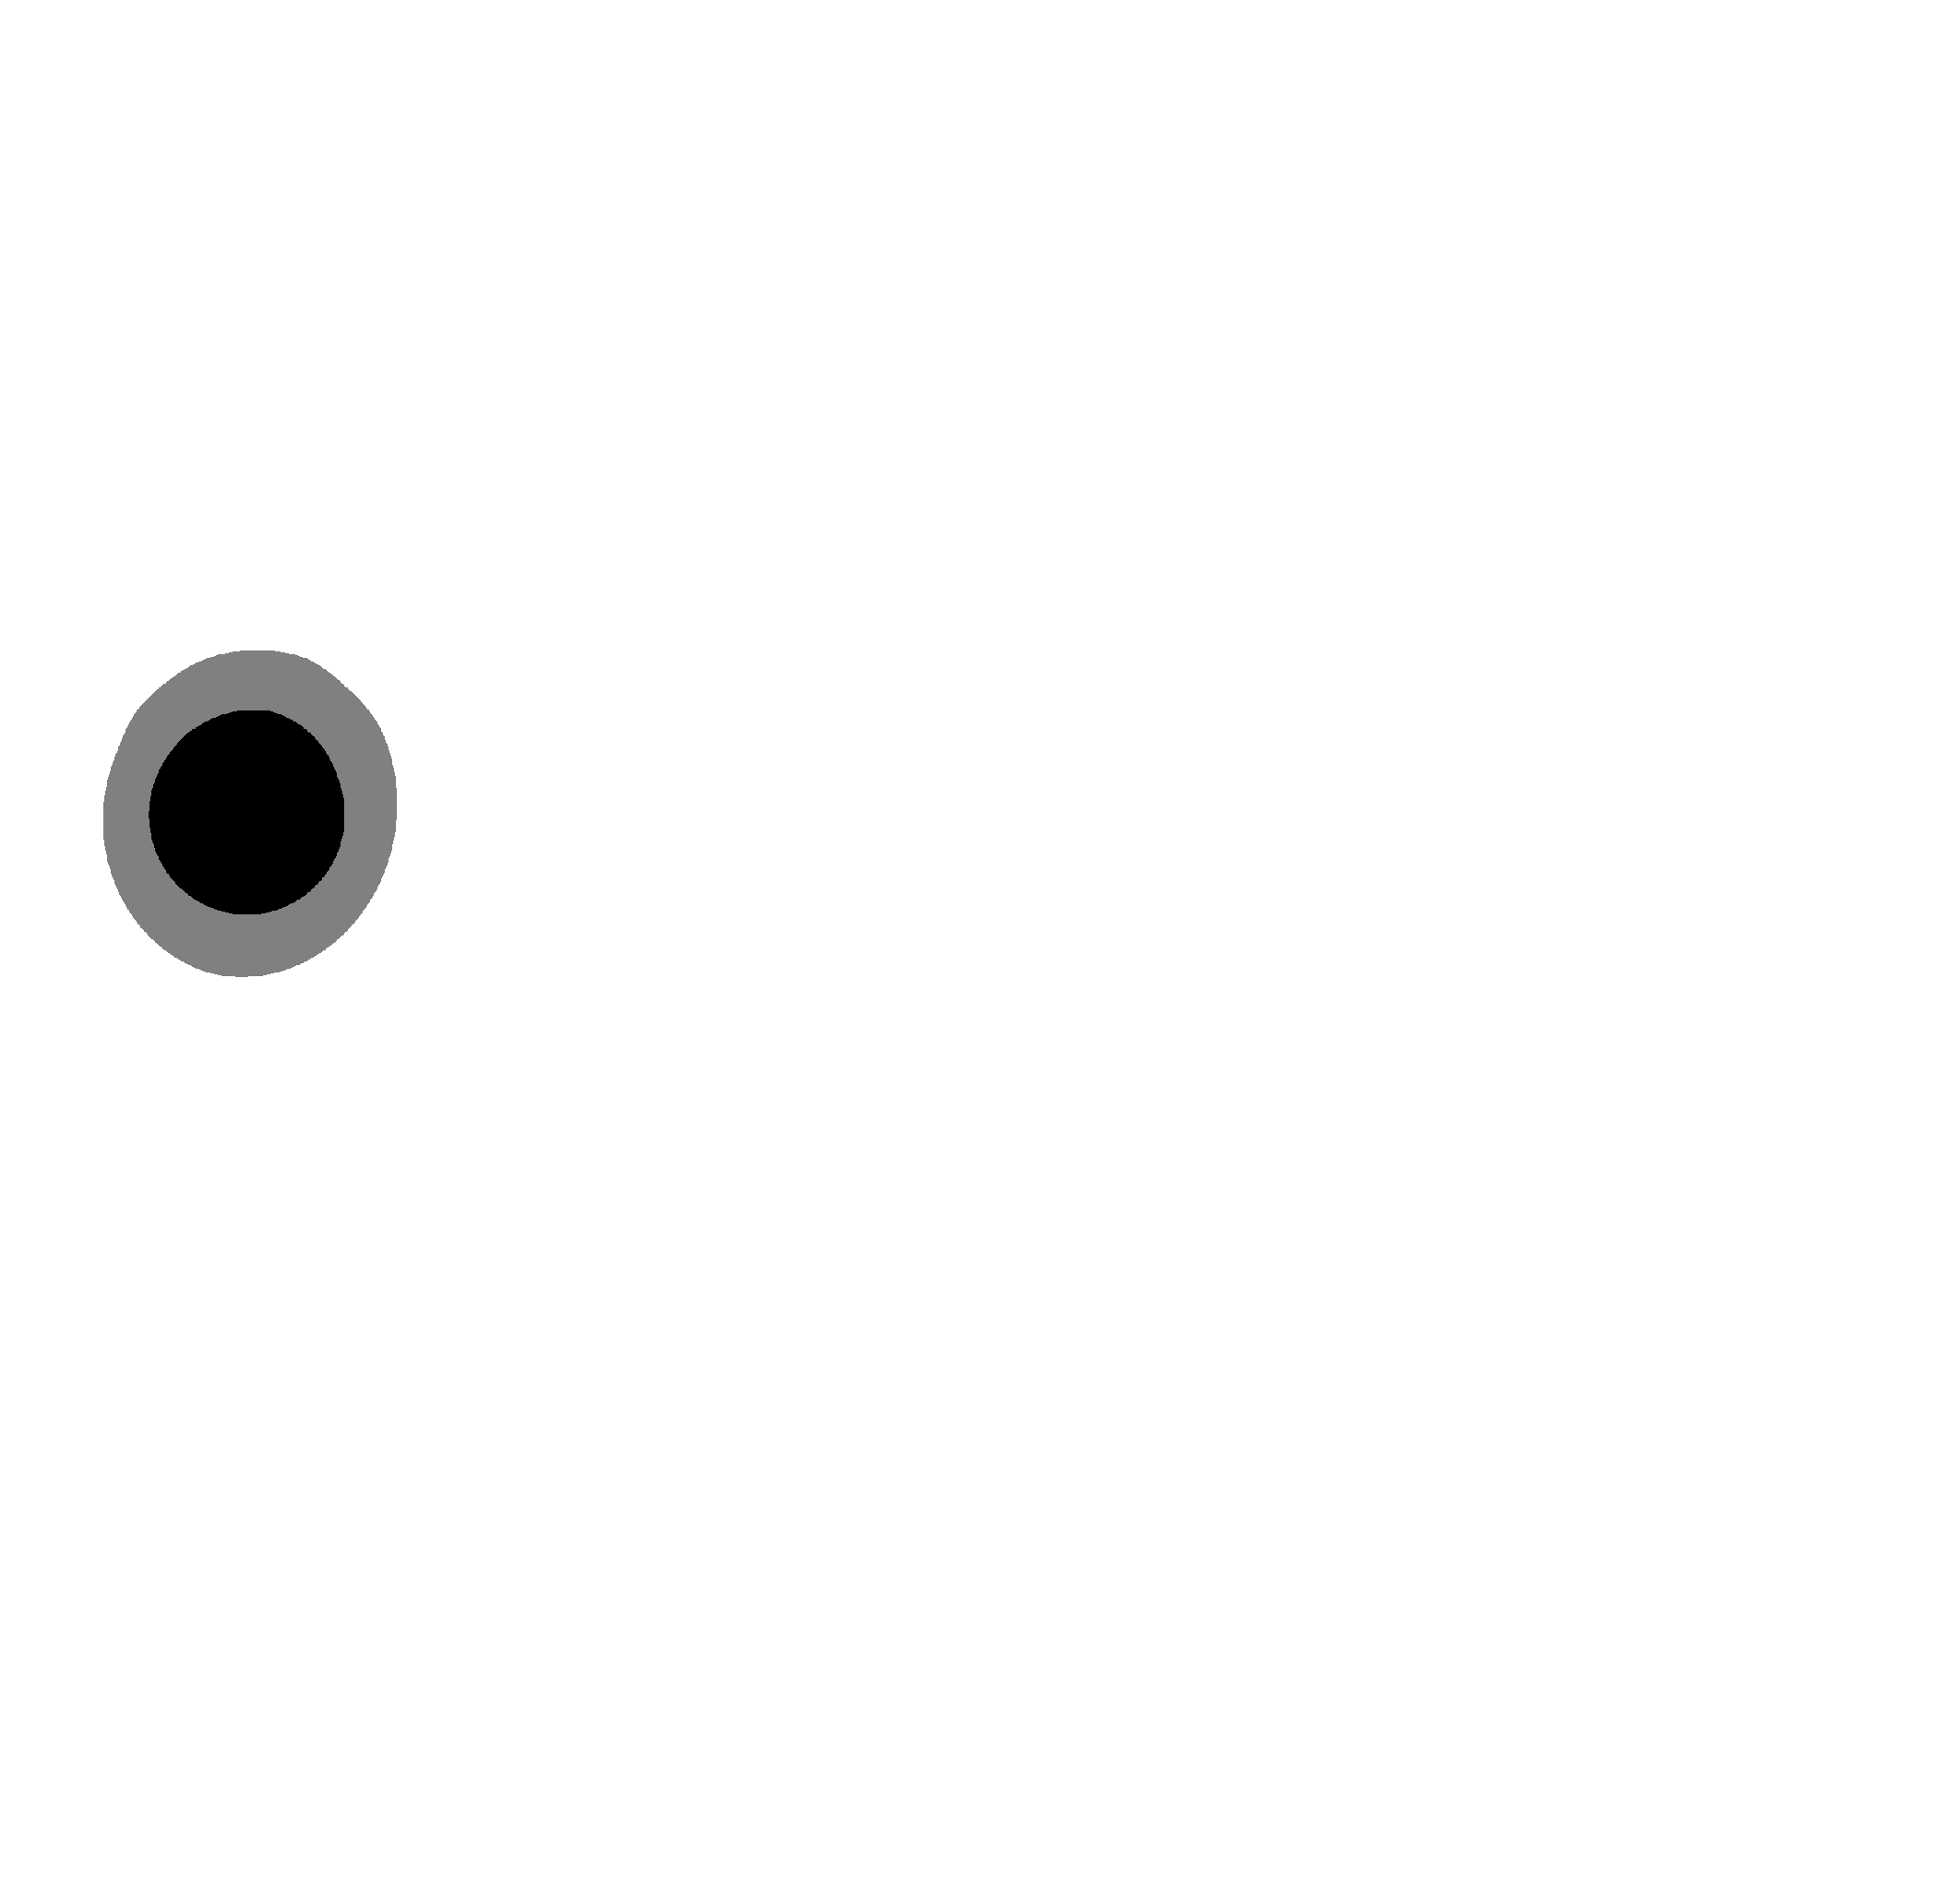

Image format: BMP
Image size: (2124, 2056)
Image mode: L


In [12]:
# open the image file using PIL
image = Image.open(train_masks[0])

# display the image
display(image)

# print the image details
print("Image format:", image.format)
print("Image size:", image.size)
print("Image mode:", image.mode)

In [13]:
train_imtrans = Compose(
    [
        LoadImage(image_only=True,ensure_channel_first=True),
#         AddChannel(),
        Resize((512, 512)),
#         RandFlip(prob=0.5, spatial_axis=0),
#         RandFlip(prob=0.5, spatial_axis=1),
#         RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ScaleIntensity(),
        ToTensor(),
    ]
)

train_segtrans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            Resize((512, 512)),
#             RandFlip(prob=0.5, spatial_axis=0),
#             RandFlip(prob=0.5, spatial_axis=1),
#             RandRotate90(prob=0.5, spatial_axes=(0, 1)),
            ScaleIntensity(),
            ToTensor(),
        ]
    )

In [14]:
val_imtrans = Compose([
    LoadImage(image_only=True, ensure_channel_first=True),
    Resize((512, 512)),
    ScaleIntensity(),
    ToTensor(),
])

val_segtrans = Compose([
    LoadImage(image_only=True, ensure_channel_first=True),
    Resize((512, 512)),
    ScaleIntensity(),
    ToTensor(),
#     AddChannel()
])

In [15]:
# create a training data loader
# train_ds = ArrayDataset(images[:20], train_imtrans, segs[:20], train_segtrans)

train_ds = ArrayDataset(train_images, train_imtrans, train_masks, train_segtrans)
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())

In [16]:
im, seg = first(train_loader)
print(im.shape, seg.shape)

C:\Users\anami\.conda\envs\ml\lib\site-packages\monai\data\__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t = cls([], dtype=storage.dtype, device=storage.device)


torch.Size([10, 3, 512, 512]) torch.Size([10, 1, 512, 512])


In [17]:
# create a validation data loader
# val_ds = ArrayDataset(images[-20:], val_imtrans, segs[-20:], val_segtrans)

val_ds = ArrayDataset(val_images, val_imtrans, val_masks, val_segtrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, shuffle=False, pin_memory=torch.cuda.is_available())

In [18]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# transforms for the output
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# post_trans_1 = Compose([ AddChannel(), Activations(sigmoid=True)])
# post_trans_2 = Compose([ Activations(sigmoid=True), AsDiscrete(threshold_values=True)])

In [19]:
# saver = SaveImage(output_dir="./output", output_ext=".png",)

epoch_num = 5

model_dir = "./models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [20]:
# create UNet, loss function, DiceLoss(?) and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
#     norm="batch",
#     dropout = 0.0
).to(device)

loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [21]:
torch.cuda.is_available()

True

### Set up training

In [22]:
seed_everything(seed=69)

In [23]:
# start a typical PyTorch training
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{10}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                roi_size = (96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "unet-model-512-epoch5.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_mean_dice", metric, epoch + 1)
            # plot the last model output as GIF image in TensorBoard with the corresponding image and label
            plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
            plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
            plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/10
1/40, train_loss: 0.2364
2/40, train_loss: 0.2282
3/40, train_loss: 0.2226
4/40, train_loss: 0.2185
5/40, train_loss: 0.2160
6/40, train_loss: 0.2139
7/40, train_loss: 0.2121
8/40, train_loss: 0.2101
9/40, train_loss: 0.2084
10/40, train_loss: 0.2068
11/40, train_loss: 0.2055
12/40, train_loss: 0.2041
13/40, train_loss: 0.2023
14/40, train_loss: 0.2013
15/40, train_loss: 0.2001
16/40, train_loss: 0.1991
17/40, train_loss: 0.1979
18/40, train_loss: 0.1973
19/40, train_loss: 0.1957
20/40, train_loss: 0.1951
21/40, train_loss: 0.1939
22/40, train_loss: 0.1928
23/40, train_loss: 0.1918
24/40, train_loss: 0.1905
25/40, train_loss: 0.1895
26/40, train_loss: 0.1893
27/40, train_loss: 0.1876
28/40, train_loss: 0.1868
29/40, train_loss: 0.1861
30/40, train_loss: 0.1851
31/40, train_loss: 0.1841
32/40, train_loss: 0.1834
33/40, train_loss: 0.1829
34/40, train_loss: 0.1815
35/40, train_loss: 0.1814
36/40, train_loss: 0.1799
37/40, train_loss: 0.1791
38/40, train_loss: 0.1783

C:\Users\anami\.conda\envs\ml\lib\site-packages\monai\metrics\utils.py:219: UserWarning: y should be a binarized tensor.
  warnings.warn(f"{name} should be a binarized tensor.")


saved new best metric model
current epoch: 1 current mean dice: 0.9895 best mean dice: 0.9895 at epoch 1
----------
epoch 2/10
1/40, train_loss: 0.1761
2/40, train_loss: 0.1755
3/40, train_loss: 0.1743
4/40, train_loss: 0.1733
5/40, train_loss: 0.1726
6/40, train_loss: 0.1721
7/40, train_loss: 0.1710
8/40, train_loss: 0.1705
9/40, train_loss: 0.1696
10/40, train_loss: 0.1689
11/40, train_loss: 0.1682
12/40, train_loss: 0.1674
13/40, train_loss: 0.1665
14/40, train_loss: 0.1658
15/40, train_loss: 0.1652
16/40, train_loss: 0.1643
17/40, train_loss: 0.1635
18/40, train_loss: 0.1626
19/40, train_loss: 0.1618
20/40, train_loss: 0.1616
21/40, train_loss: 0.1605
22/40, train_loss: 0.1598
23/40, train_loss: 0.1591
24/40, train_loss: 0.1581
25/40, train_loss: 0.1577
26/40, train_loss: 0.1567
27/40, train_loss: 0.1563
28/40, train_loss: 0.1552
29/40, train_loss: 0.1546
30/40, train_loss: 0.1543
31/40, train_loss: 0.1531
32/40, train_loss: 0.1523
33/40, train_loss: 0.1516
34/40, train_loss: 0.151

In [ ]:
# C:\Users\anami\.conda\envs\ml\lib\site-packages\monai\metrics\utils.py:219: UserWarning: y should be a binarized tensor.
#   warnings.warn(f"{name} should be a binarized tensor.")

# See this warning in the output of the training loop. This is the indication of the error we're facing.

In [27]:
# savepath = "model_4epoch.pth"
# torch.save(model.state_dict(), savepath)

In [24]:
model.load_state_dict(torch.load("unet-model-512-epoch5.pth"))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

In [25]:
saver = SaveImage(output_dir="./output", output_ext=".png",)

In [26]:
with torch.no_grad():
    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        # define sliding window size and batch size for windows inference
        roi_size = (96, 96)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        val_labels = decollate_batch(val_labels)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)
        metric = dice_metric.aggregate().item()
        for val_output in val_outputs:
            print(f"Dice metric: {metric}")
            saver(val_output)

Dice metric: 0.994431734085083
2023-04-22 21:29:21,233 INFO image_writer.py:194 - writing: output\V0001\V0001_trans.png
Dice metric: 0.99440598487854
2023-04-22 21:29:21,490 INFO image_writer.py:194 - writing: output\V0002\V0002_trans.png
Dice metric: 0.9940060973167419
2023-04-22 21:29:21,735 INFO image_writer.py:194 - writing: output\V0003\V0003_trans.png
Dice metric: 0.9945405125617981
2023-04-22 21:29:21,949 INFO image_writer.py:194 - writing: output\V0004\V0004_trans.png
Dice metric: 0.9950090646743774
2023-04-22 21:29:22,159 INFO image_writer.py:194 - writing: output\V0005\V0005_trans.png
Dice metric: 0.9945542216300964
2023-04-22 21:29:22,405 INFO image_writer.py:194 - writing: output\V0006\V0006_trans.png
Dice metric: 0.9947795867919922
2023-04-22 21:29:22,642 INFO image_writer.py:194 - writing: output\V0007\V0007_trans.png
Dice metric: 0.9949767589569092
2023-04-22 21:29:22,861 INFO image_writer.py:194 - writing: output\V0008\V0008_trans.png
Dice metric: 0.9949361085891724
202

Dice metric: 0.9946722388267517
2023-04-22 21:29:37,038 INFO image_writer.py:194 - writing: output\V0069\V0069_trans.png
Dice metric: 0.9946489334106445
2023-04-22 21:29:37,267 INFO image_writer.py:194 - writing: output\V0070\V0070_trans.png
Dice metric: 0.9946708083152771
2023-04-22 21:29:37,506 INFO image_writer.py:194 - writing: output\V0071\V0071_trans.png
Dice metric: 0.9946693778038025
2023-04-22 21:29:37,716 INFO image_writer.py:194 - writing: output\V0072\V0072_trans.png
Dice metric: 0.9946908950805664
2023-04-22 21:29:37,975 INFO image_writer.py:194 - writing: output\V0073\V0073_trans.png
Dice metric: 0.9947077035903931
2023-04-22 21:29:38,198 INFO image_writer.py:194 - writing: output\V0074\V0074_trans.png
Dice metric: 0.994673490524292
2023-04-22 21:29:38,414 INFO image_writer.py:194 - writing: output\V0075\V0075_trans.png
Dice metric: 0.994671642780304
2023-04-22 21:29:38,634 INFO image_writer.py:194 - writing: output\V0076\V0076_trans.png
Dice metric: 0.9946625828742981
20

Dice metric: 0.9947208762168884
2023-04-22 21:29:52,486 INFO image_writer.py:194 - writing: output\V0137\V0137_trans.png
Dice metric: 0.9947333931922913
2023-04-22 21:29:52,698 INFO image_writer.py:194 - writing: output\V0138\V0138_trans.png
Dice metric: 0.9947435259819031
2023-04-22 21:29:52,913 INFO image_writer.py:194 - writing: output\V0139\V0139_trans.png
Dice metric: 0.9947404265403748
2023-04-22 21:29:53,139 INFO image_writer.py:194 - writing: output\V0140\V0140_trans.png
Dice metric: 0.9947535991668701
2023-04-22 21:29:53,356 INFO image_writer.py:194 - writing: output\V0141\V0141_trans.png
Dice metric: 0.994752049446106
2023-04-22 21:29:53,573 INFO image_writer.py:194 - writing: output\V0142\V0142_trans.png
Dice metric: 0.9947628378868103
2023-04-22 21:29:53,780 INFO image_writer.py:194 - writing: output\V0143\V0143_trans.png
Dice metric: 0.994765043258667
2023-04-22 21:29:53,991 INFO image_writer.py:194 - writing: output\V0144\V0144_trans.png
Dice metric: 0.9947476387023926
20

Dice metric: 0.9947822093963623
2023-04-22 21:30:07,836 INFO image_writer.py:194 - writing: output\V0205\V0205_trans.png
Dice metric: 0.9947835803031921
2023-04-22 21:30:08,059 INFO image_writer.py:194 - writing: output\V0206\V0206_trans.png
Dice metric: 0.9947816133499146
2023-04-22 21:30:08,302 INFO image_writer.py:194 - writing: output\V0207\V0207_trans.png
Dice metric: 0.9947671294212341
2023-04-22 21:30:08,549 INFO image_writer.py:194 - writing: output\V0208\V0208_trans.png
Dice metric: 0.9947717189788818
2023-04-22 21:30:08,761 INFO image_writer.py:194 - writing: output\V0209\V0209_trans.png
Dice metric: 0.9947720766067505
2023-04-22 21:30:08,993 INFO image_writer.py:194 - writing: output\V0210\V0210_trans.png
Dice metric: 0.9947746992111206
2023-04-22 21:30:09,207 INFO image_writer.py:194 - writing: output\V0211\V0211_trans.png
Dice metric: 0.9947711825370789
2023-04-22 21:30:09,460 INFO image_writer.py:194 - writing: output\V0212\V0212_trans.png
Dice metric: 0.9947778582572937


Dice metric: 0.9947279691696167
2023-04-22 21:30:22,738 INFO image_writer.py:194 - writing: output\V0273\V0273_trans.png
Dice metric: 0.9947285056114197
2023-04-22 21:30:22,940 INFO image_writer.py:194 - writing: output\V0274\V0274_trans.png
Dice metric: 0.9947332143783569
2023-04-22 21:30:23,168 INFO image_writer.py:194 - writing: output\V0275\V0275_trans.png
Dice metric: 0.9947322010993958
2023-04-22 21:30:23,379 INFO image_writer.py:194 - writing: output\V0276\V0276_trans.png
Dice metric: 0.9947319030761719
2023-04-22 21:30:23,586 INFO image_writer.py:194 - writing: output\V0277\V0277_trans.png
Dice metric: 0.9947376847267151
2023-04-22 21:30:23,785 INFO image_writer.py:194 - writing: output\V0278\V0278_trans.png
Dice metric: 0.9947417974472046
2023-04-22 21:30:23,994 INFO image_writer.py:194 - writing: output\V0279\V0279_trans.png
Dice metric: 0.9947395324707031
2023-04-22 21:30:24,207 INFO image_writer.py:194 - writing: output\V0280\V0280_trans.png
Dice metric: 0.9947448968887329


Dice metric: 0.9947741627693176
2023-04-22 21:30:37,438 INFO image_writer.py:194 - writing: output\V0341\V0341_trans.png
Dice metric: 0.9947661757469177
2023-04-22 21:30:37,635 INFO image_writer.py:194 - writing: output\V0342\V0342_trans.png
Dice metric: 0.9947682619094849
2023-04-22 21:30:37,831 INFO image_writer.py:194 - writing: output\V0343\V0343_trans.png
Dice metric: 0.9947646260261536
2023-04-22 21:30:38,044 INFO image_writer.py:194 - writing: output\V0344\V0344_trans.png
Dice metric: 0.9947608709335327
2023-04-22 21:30:38,253 INFO image_writer.py:194 - writing: output\V0345\V0345_trans.png
Dice metric: 0.9947578310966492
2023-04-22 21:30:38,468 INFO image_writer.py:194 - writing: output\V0346\V0346_trans.png
Dice metric: 0.9947309494018555
2023-04-22 21:30:38,683 INFO image_writer.py:194 - writing: output\V0347\V0347_trans.png
Dice metric: 0.9947350025177002
2023-04-22 21:30:38,877 INFO image_writer.py:194 - writing: output\V0348\V0348_trans.png
Dice metric: 0.9947385787963867


In [87]:
# aggregate the final mean dice result
print("evaluation metric:", dice_metric.aggregate().item())

evaluation metric: 0.6855282187461853


In [ ]:
# reset the status
dice_metric.reset()